# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.colors import Colormap
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [4]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [5]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

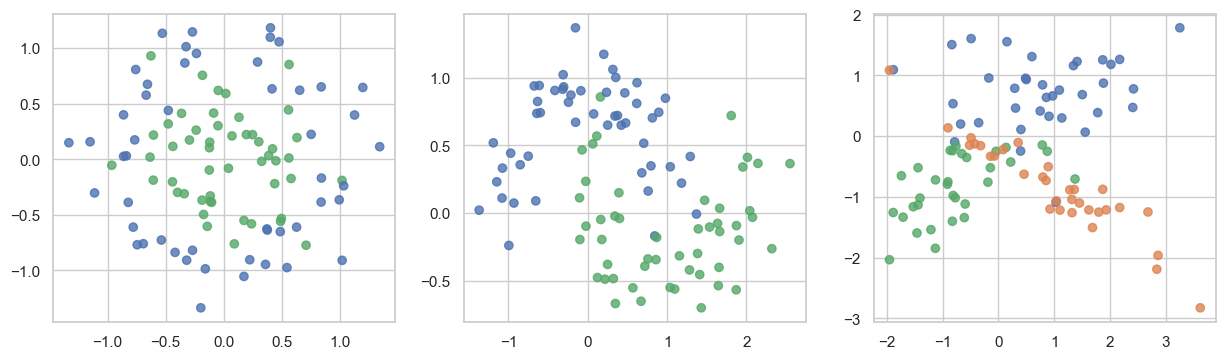

In [6]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [7]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

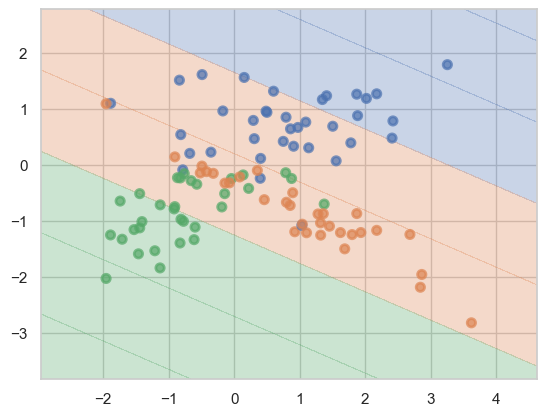

In [8]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [9]:
ds_names = {0: 'Circles', 1: 'Moons', 2: 'Classes'}
def test_dtc_on_datasets(max_depth=None, min_samples_leaf=1):
  plt.figure(figsize=(15, 6))
  plt.suptitle(
      f'DecisionTreeClassifier [depth: {max_depth}, min_samples_leaf: {min_samples_leaf}]')
  for i, (x, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, train_size=0.8, random_state=666)
    dtc = DecisionTreeClassifier().fit(X_train, y_train)
    plt.subplot(1, 3, 1+i)
    plt.title(
        f'{ds_names[i]}: [train: {dtc.score(X_train, y_train):.3f}, test: {dtc.score(X_test, y_test):.3f}]')
    plot_surface(dtc, X_train, y_train)

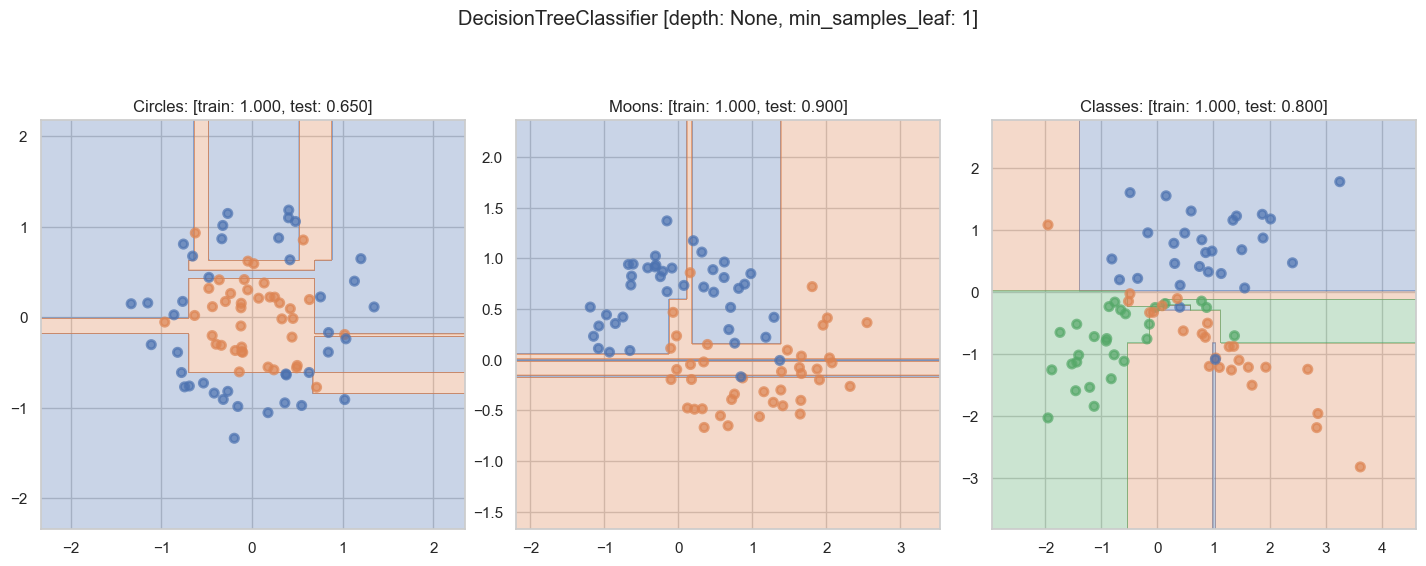

In [10]:
test_dtc_on_datasets()

---

__Вопрос:__ Сильно ли деревья переобучились?

__Ответ:__ ```Точность на трейне 1, а на тесте для всех 3 наборов данных сильно ниже, что свидетельствует о переобучении```

---

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

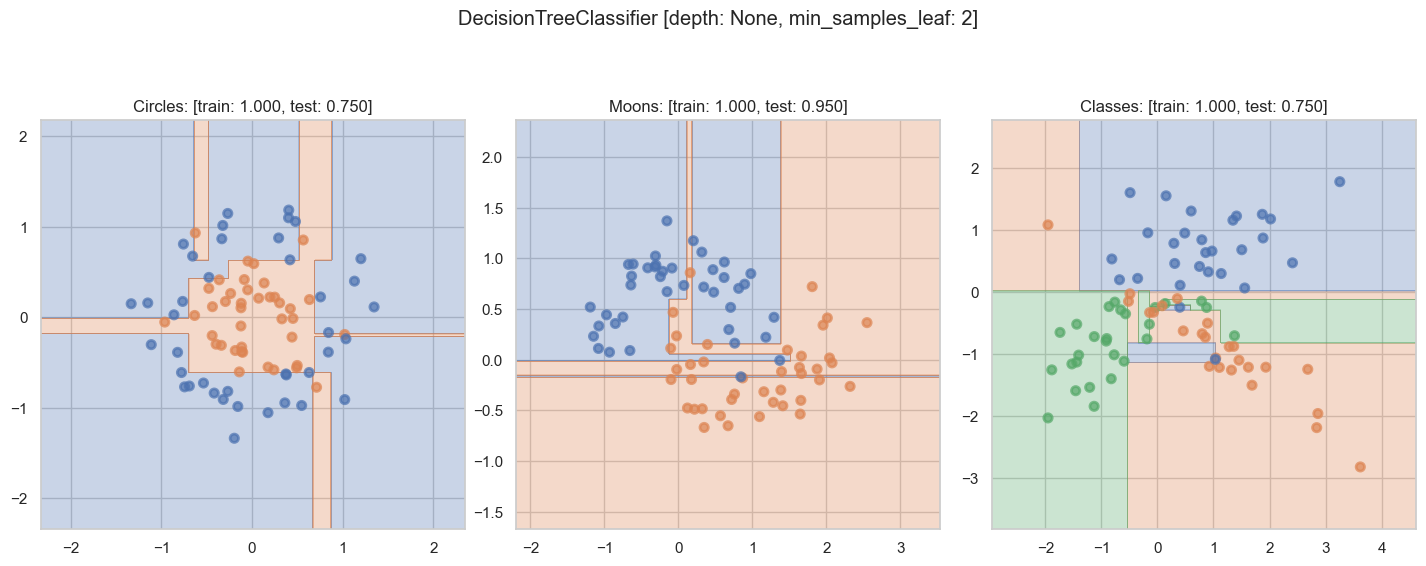

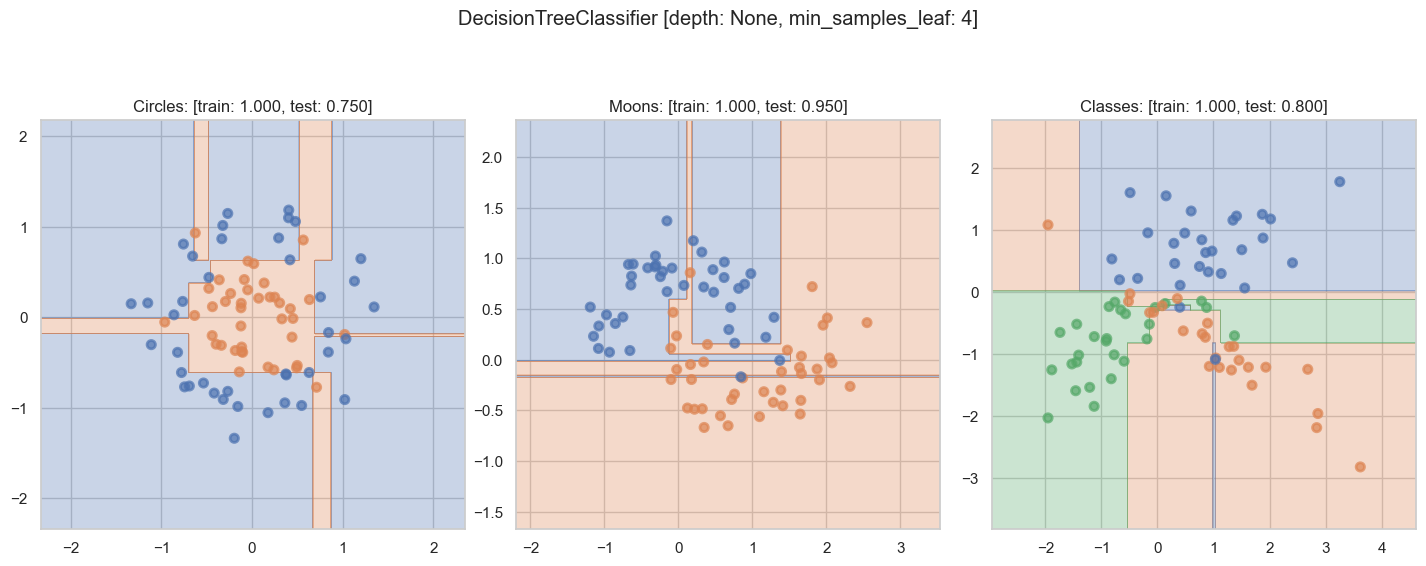

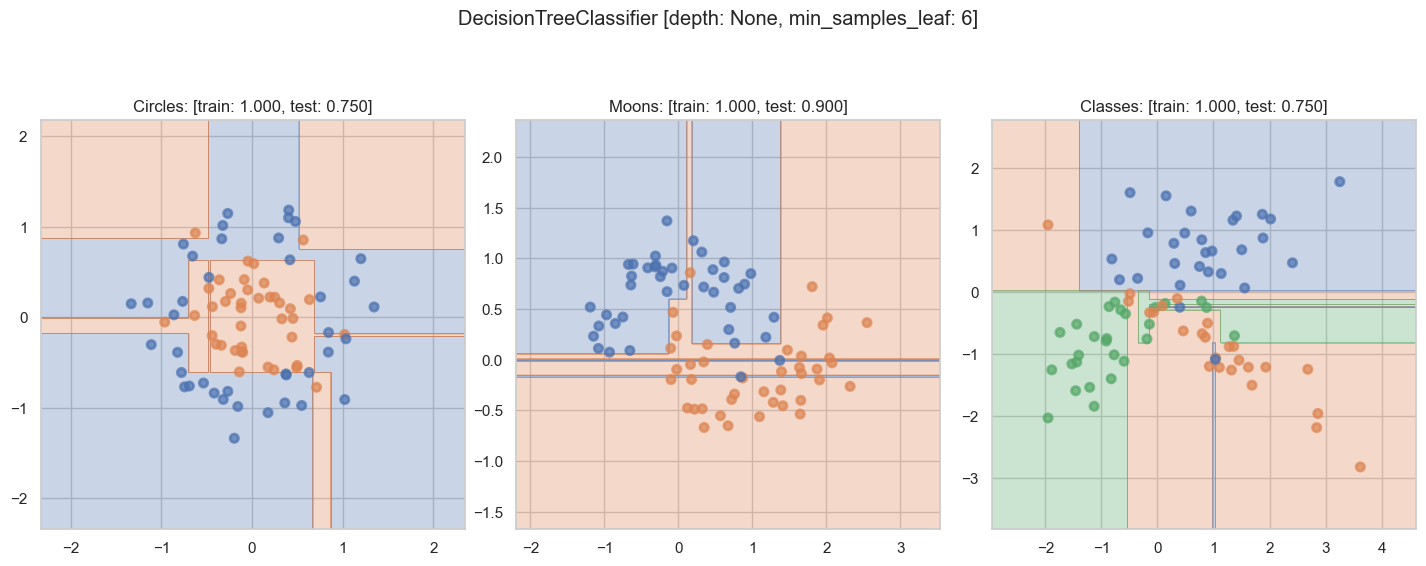

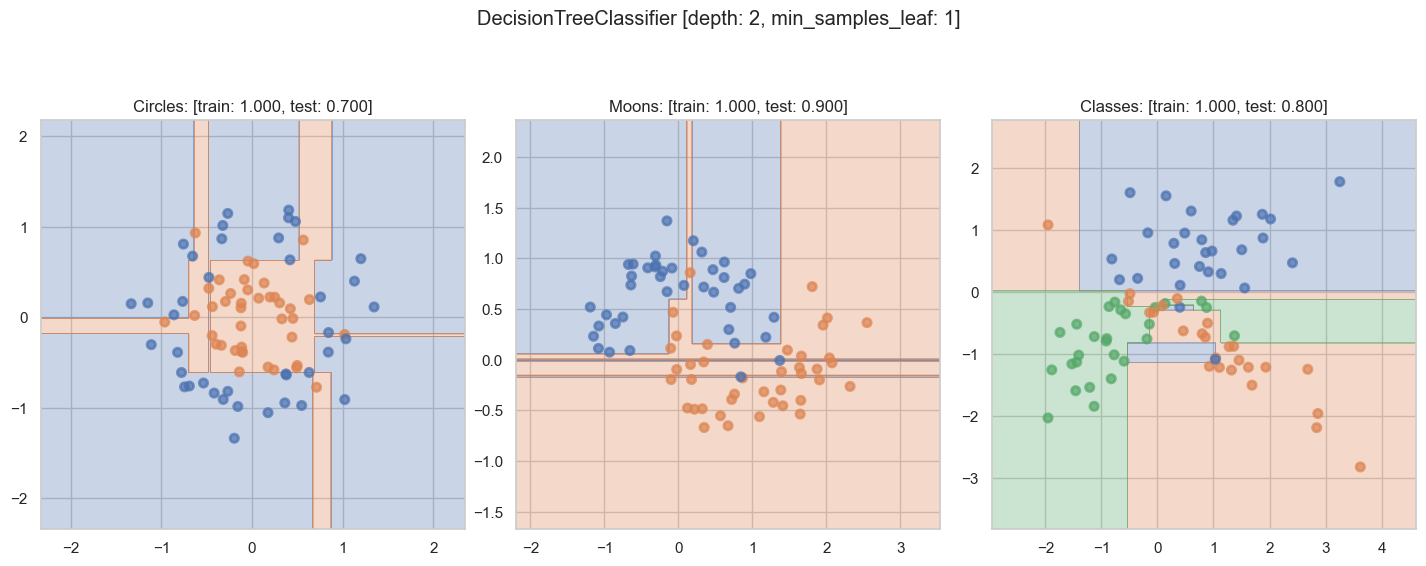

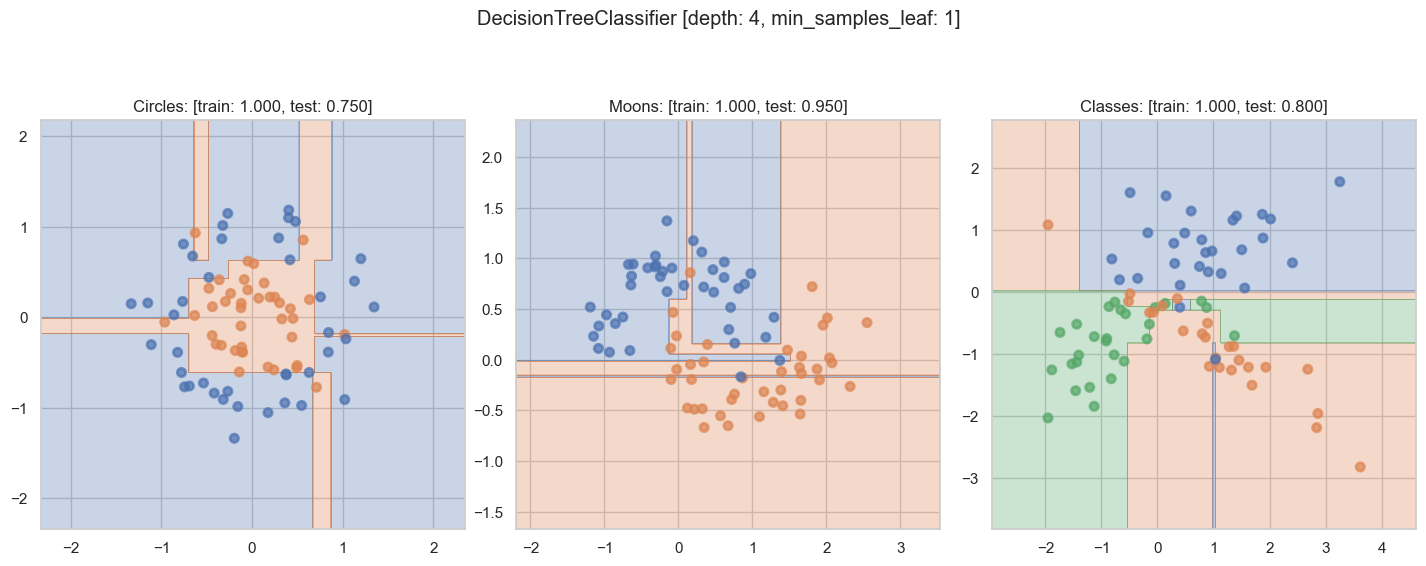

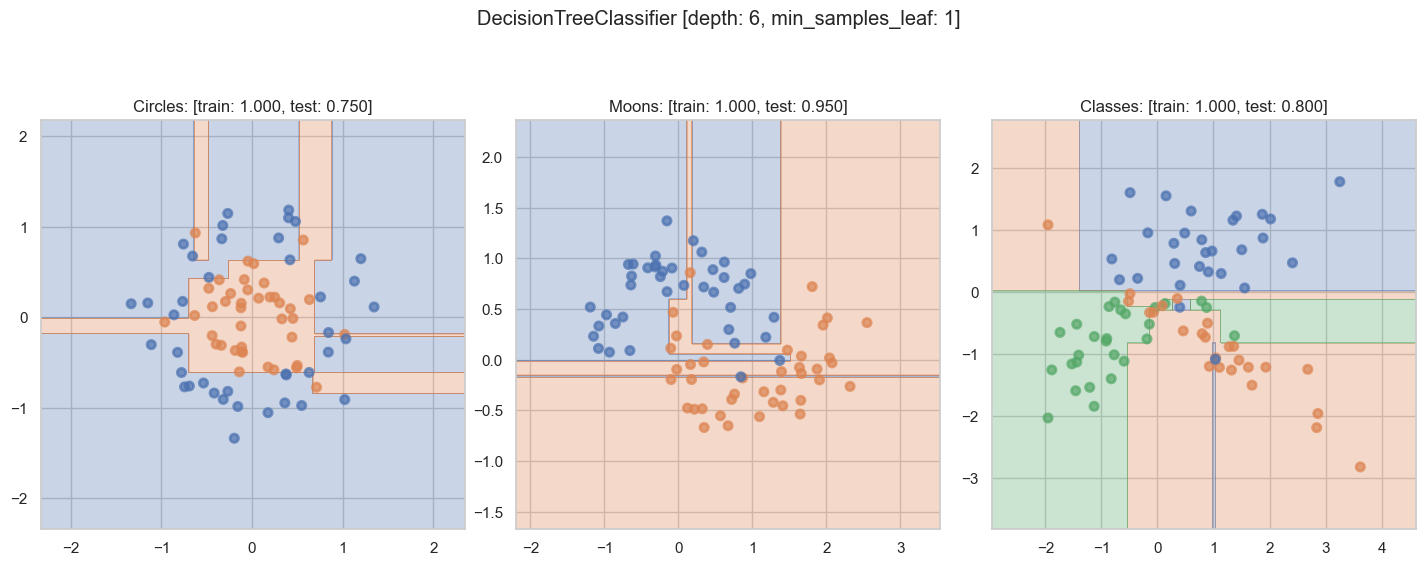

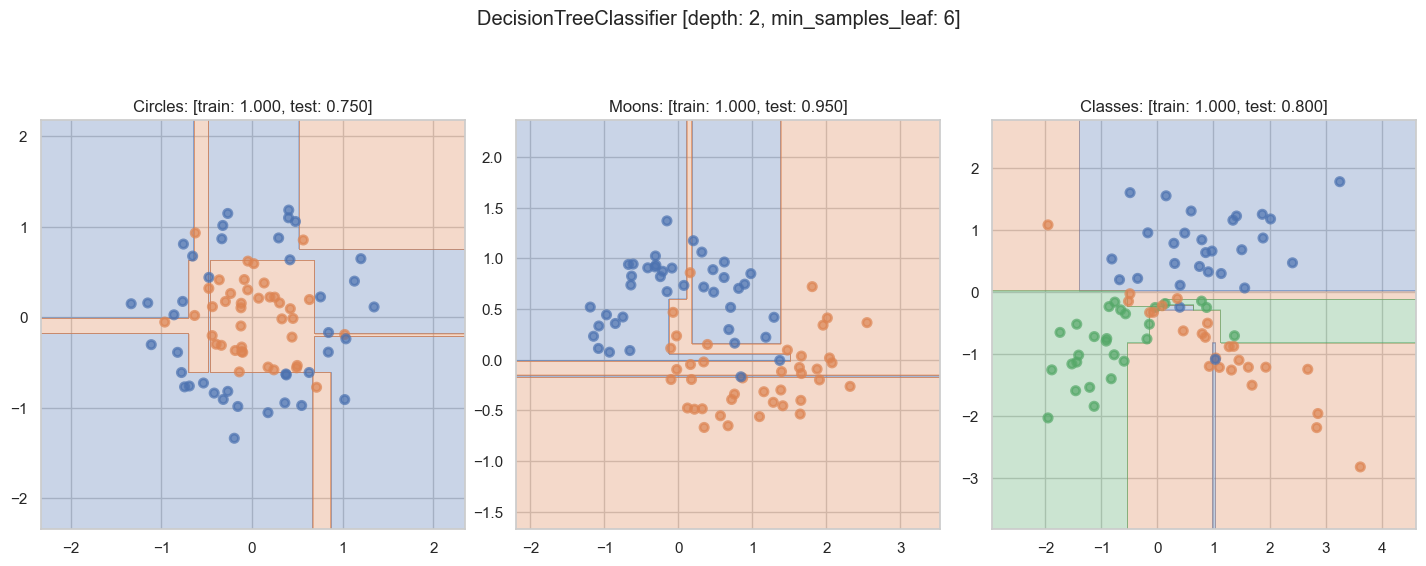

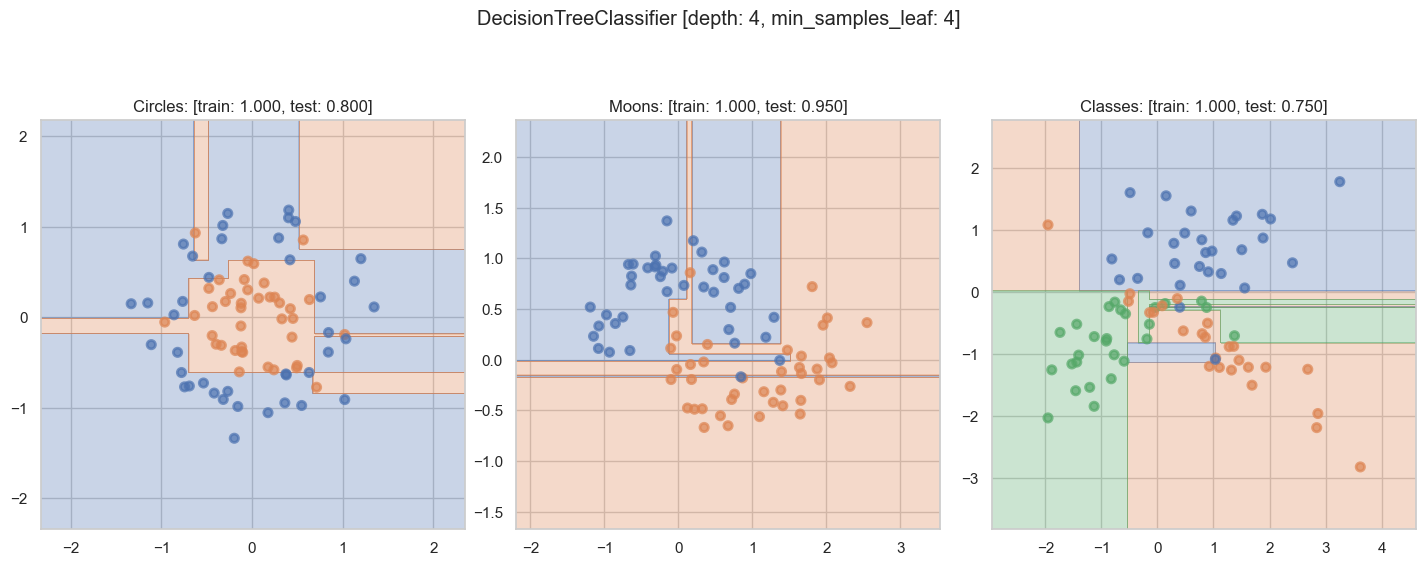

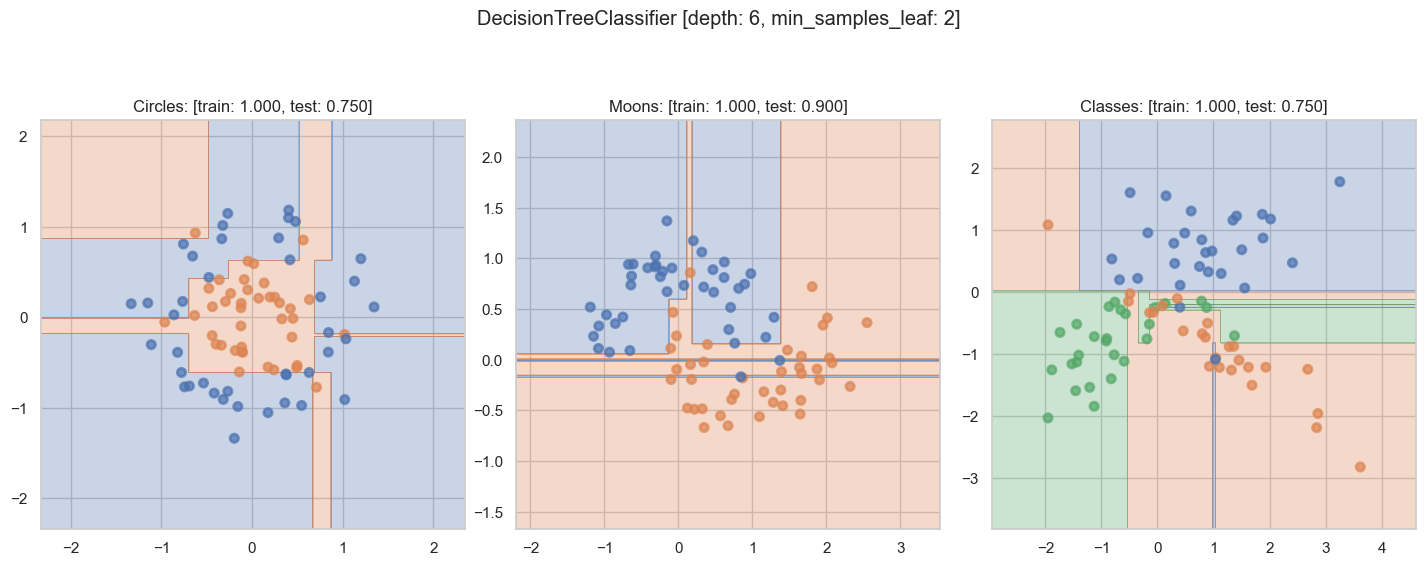

In [11]:
#         depth, leaf|depth, leaf|depth, leaf
configs = [(None, 2),  (None, 4),  (None, 6),
           (2, 1),     (4, 1),     (6, 1),
           (2, 6),     (4, 4),     (6, 2)]

for (max_depth, min_samples_leaf) in configs:
  test_dtc_on_datasets(max_depth, min_samples_leaf)

---

__Вопрос:__ Почему так происходит, одинаково ли изменение для разных датасетов?

__Ответ:__ 

`max_depth`, `min_samples_leaf`

Увеличение `min_samples_leaf` и уменьшение `max_depth` приводят к упрощению модели и повышению обобщающей способности - дерево меньше переобучается.

Лучшие параметры 

```
Для `Сircles`: [max_depth: 6, min_leaf: 2]
               [max_depth: -, min_leaf: 6]

Для `Moons`: одинаково хорошо на всех параметрах, кроме:
             [max_depth: -, min_leaf: 6] и 
             [max_depth: 6, min_leaf: 2]
             (противоположно Сircles, так как нужна более сложная модель)

Для `Classes`: [max_depth: 6, min_leaf: 1]
               [max_depth: 2, min_leaf: 1]
               [max_depth: 2, min_leaf: 6]
               тут все просто

```

---

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

In [49]:
import hw5code as hwc
from importlib import reload
reload(hwc)

<module 'hw5code' from '/Users/kraalex/hse/hse-hw/ml/5/hw5code.py'>

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых 'порог — значение критерия Джини' для всех пяти признаков. Отдельно визуализируйте scatter-графики 'значение признака — класс' для всех пяти признаков.

In [48]:
students_df = pd.read_csv('students.csv')
students_df.sample()

,STG,SCG,STR,LPR,PEG,UNS
101,0.3,0.32,0.31,0.33,0.87,1


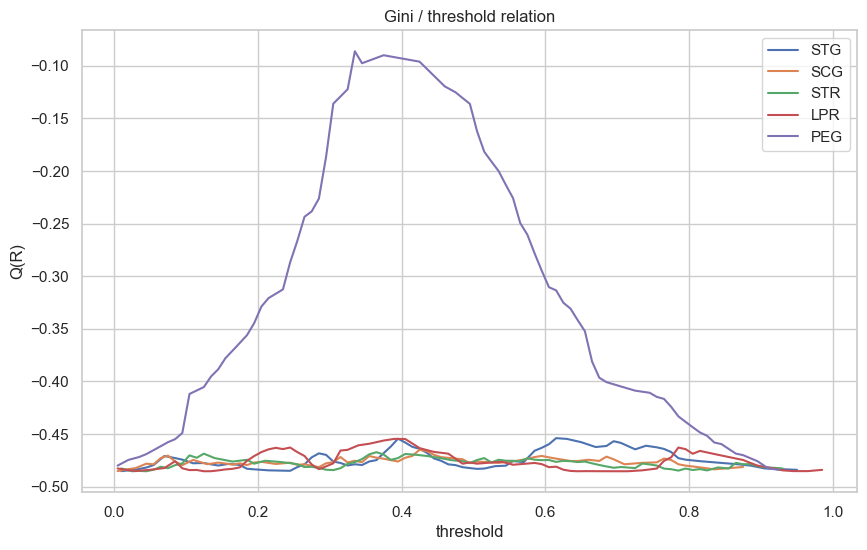

In [50]:
students_target_df = students_df['UNS']
students_features_df = students_df.drop(columns='UNS')

plt.figure(figsize=(10, 6))
for col in students_features_df.columns:
  thresholds, ginis, t_best, gini_best = hwc.find_best_split(
      students_features_df[col].values, students_target_df.values)
  plt.plot(thresholds, ginis, label=col)
plt.title('Gini / threshold relation')
plt.xlabel('threshold')
plt.ylabel('Q(R)')
plt.legend()

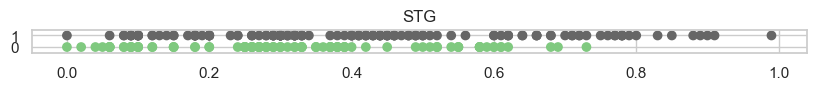

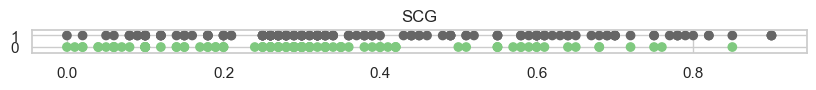

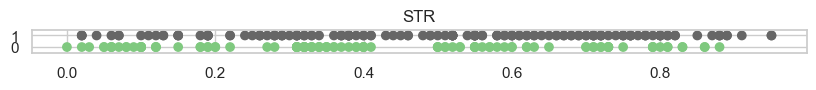

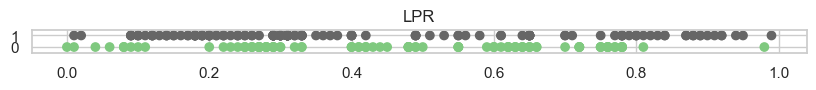

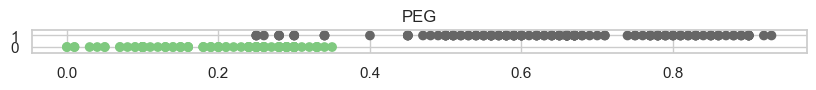

In [51]:
for i, column_name in enumerate(students_features_df.columns):
    plt.figure(figsize=(10,0.3))
    plt.scatter(
        x=students_features_df[column_name].values,
        y=students_target_df.values, 
        c= students_target_df.values, cmap='Accent')
    plt.title(column_name)
    plt.ylim([-0.5, 1.5])

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для 'хороших' признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

---

**Ответ:** 
```
Разделить нужно по 'PEG', т.к. значения этого признака почти отсортированы по возрастанию, что позволяет нам разделить данные на две части (через 0.3-0.4), в каждой из которых преимущественно присутствуют объекты с одинаковым значением таргета. 

По графику 'Gini / threshold relation' также это видно (максимум в точке 0.3-0.4)
```

---

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

```DONE```

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [59]:
mushrooms_df = pd.read_csv('agaricus-lepiota.data')
mushrooms_df.sample()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
2968,e,f,f,n,t,n,f,c,b,u,...,s,g,p,p,w,o,p,n,y,d


In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

for col in mushrooms_df.columns:
    mushrooms_df.loc[:, col] = LabelEncoder(
    ).fit_transform(mushrooms_df.loc[:, col])

target = mushrooms_df['p']
features = mushrooms_df.drop(columns='p')


X_train, X_test, y_train, y_test = train_test_split(features.values, target.values,
                                                    test_size=0.5, random_state=666)
f_types = ['categorical'] * X_train.shape[1]

model = hwc.DecisionTree(f_types).fit(X_train, y_train)

test_acc = np.sum(model.predict(X_test) == y_test) / np.size(y_test)
train_acc = np.sum(model.predict(X_train) == y_train) / np.size(y_train)
print(f'Test accuracy : {test_acc:.3f}')
print(f'Train accuracy: {train_acc:.3f}')
print(f'Depth: {model.get_depth()}')

Test accuracy : 1.000
Train accuracy: 1.000
Depth: 8


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [104]:
mushrooms_df = pd.read_csv('agaricus-lepiota.data')
tic_tac_df = pd.read_csv('tic-tac-toe-endgame.csv')
car_df = pd.read_csv('car+evaluation/car.data')
nursery_df = pd.read_csv('nursery/nursery.data')

display(mushrooms_df.sample())
display(tic_tac_df.sample())
display(car_df.sample())
display(nursery_df.sample())

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
2374,p,f,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,v,u


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
609,b,b,o,x,x,x,o,x,o,positive


,vhigh,vhigh.1,2,2.1,small,low,unacc
1060,med,high,5more,2,big,high,unacc


,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
2994,usual,critical,completed,more,less_conv,convenient,problematic,priority,spec_prior


In [105]:
car_df.loc[
    (car_df['unacc'] == 'unacc') |
    (car_df['unacc'] == 'acc')] = '0'
car_df.loc[
    (car_df['unacc'] == 'vgood') |
    (car_df['unacc'] == 'good')] = '1'

nursery_df.loc[
    (nursery_df['recommend'] == 'not_recom') |
    (nursery_df['recommend'] == 'not_recom')] = '0'
nursery_df.loc[
    (nursery_df['recommend'] == 'very_recom') |
    (nursery_df['recommend'] == 'priority') |
    (nursery_df['recommend'] == 'spec_prior')] = '1'

In [107]:
for df in [mushrooms_df, tic_tac_df, car_df, nursery_df]:
  for col in df.columns:
    df.loc[:, col] = LabelEncoder(
    ).fit_transform(df.loc[:, col])

In [114]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score


def mean_cvscore(modes, x, y):
  return cross_val_score(modes, x, y, cv=10, scoring='accuracy', verbose=2).mean()


def count_scores(feature_vector, target_vector):
  r_m = hwc.DecisionTree(['real' for x in feature_vector.columns])
  c_m = hwc.DecisionTree(['categorical' for x in feature_vector.columns])
  f_transformed = OneHotEncoder(sparse=False).fit_transform(feature_vector)
  t_m = hwc.DecisionTree(['real'] * f_transformed.shape[1])
  dtc = DecisionTreeClassifier()
  return {
      'real': mean_cvscore(r_m, feature_vector.values, target_vector),
      'categorical': mean_cvscore(c_m, feature_vector.values, target_vector),
      'ohe_real': mean_cvscore(t_m, f_transformed, target_vector,),
      'dtc': mean_cvscore(dtc, feature_vector.values, target_vector,)
  }

In [109]:
featuress = []
featuress.append(mushrooms_df.drop(columns=['p']).astype(int))
featuress.append(car_df.drop(columns=['unacc']).astype(int))
featuress.append(tic_tac_df.drop(columns=['V10']).astype(int))
featuress.append(nursery_df.drop(columns=['recommend']).astype(int))

targetss = []
targetss.append(mushrooms_df.loc[:, 'p'].values.astype(int))
targetss.append(car_df.loc[:, 'unacc'].values.astype(int))
targetss.append(tic_tac_df.loc[:, 'V10'].values.astype(int))
targetss.append(nursery_df.loc[:, 'recommend'].values.astype(int))


In [115]:
metrics = pd.DataFrame(columns=['real', 'categorical', 'ohe_real', 'dtc'])
for i, ds_name in enumerate(['mushrooms', 'cars', 'ttt', 'nursery']):
    scores = count_scores(featuress[i], targetss[i]).values()
    metrics.loc[ds_name] = list(scores)
display(metrics)

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

,real,categorical,ohe_real,dtc
mushrooms,0.999261,1.000000,0.999631,0.958290
cars,0.942600,0.967519,0.921767,0.944371
ttt,0.467533,0.541458,0.543575,0.787303
nursery,0.999923,0.999923,0.999923,0.999923


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания:

ВИДЕО: https://youtu.be/LsNADBZe4bY?si=s7SWQfpkIOH5Tv-z


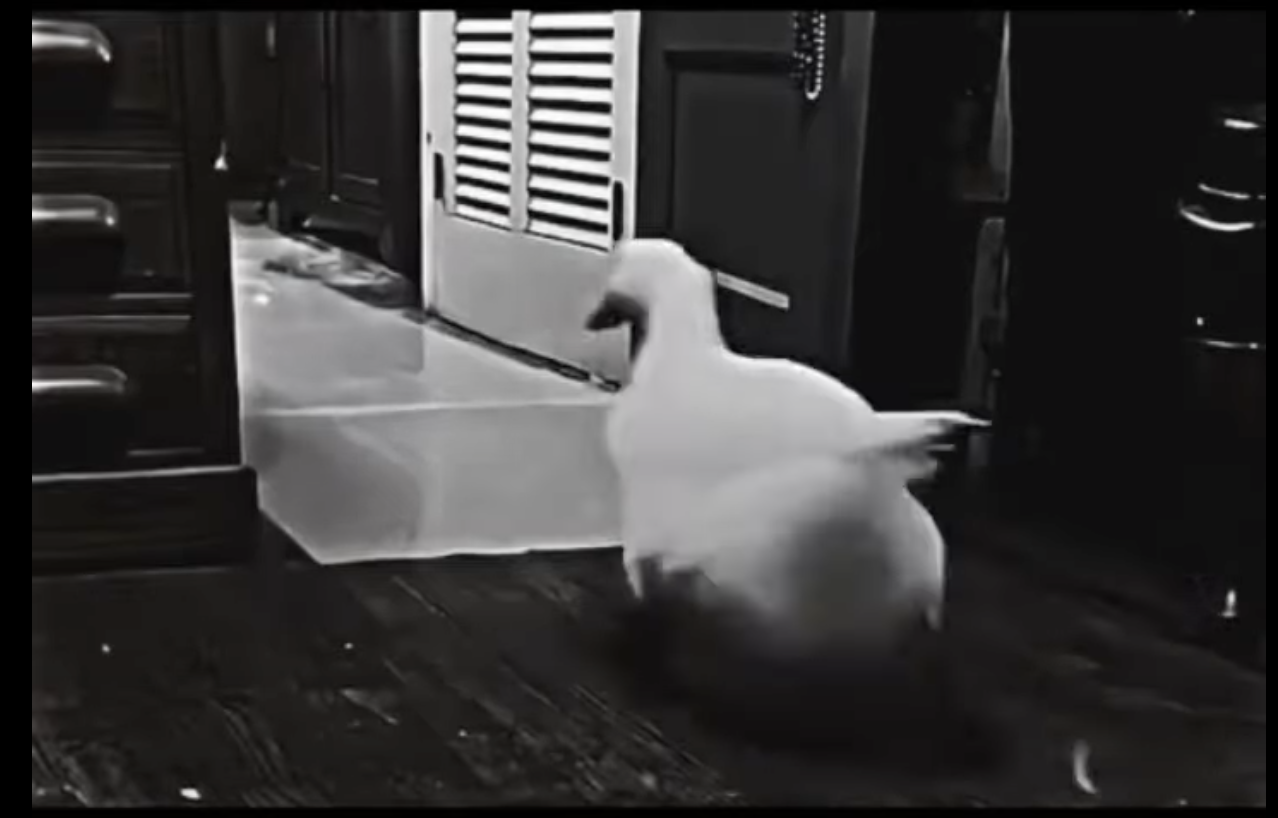